In [1]:
!nvidia-smi
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_VISIBLE_DEVICES

Wed Jun  9 14:20:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   57C    P0    65W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

'0'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torchaudio
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
from glob import glob
from datetime import datetime
import numpy as np
from WaveNetTTS.model import WaveNet
import os
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
random.seed(12)
os.environ['PYTHONHASHSEED'] = str(12)
np.random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [5]:
sp_freq = 4000
seq_len = 4000
bins = 128
batch_size = 58
channels = 256
kernel_size = 2
dilation_depth = 9
blocks = 2
condition_size = 256

MuLawEncoding = torchaudio.transforms.MuLawEncoding(quantization_channels=bins)
MuLawDecoding = torchaudio.transforms.MuLawDecoding(bins)
Resample = torchaudio.transforms.Resample(16000, sp_freq)

hugging_face_model = 'bert-base-uncased'#'distilbert-base-uncased'#
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', hugging_face_model)

Using cache found in /zhome/22/c/137477/.cache/torch/hub/huggingface_pytorch-transformers_master


In [6]:
model = WaveNet(quantization_bins=bins, kernel_size=kernel_size, channels=channels, dilation_depth=dilation_depth, blocks=blocks, condition_size=condition_size, global_condition=True, local_condition=True)
model = model.to(device)

Using cache found in /zhome/22/c/137477/.cache/torch/hub/huggingface_pytorch-transformers_master


In [7]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 123869568


In [8]:
import numpy as np
from tqdm.notebook import tqdm
import torchaudio
import torch
import torch.nn.functional as F

@torch.no_grad()
def synthesize(transcripts, waveform_sizes, model, tokenizer, device, seed=None, temperature=1.0):
    T = max(waveform_sizes)
    #Tokenize the transcript with the BERT tokenizer
    with torch.no_grad():
        model.eval()
        tokens = tokenizer(transcripts, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt', padding=True)['input_ids'].to(device)

        #Feed into sentence embedding class
        gc_embed, lc_embed = model.sentence_embedding(tokens)

        #Interpolate the locally conditioned signal from BERT so it fits with the waveform size and then trim the same portion of the signal as for the waveform.
        lc_embed = F.interpolate(lc_embed, size=T)
        lc_embed = F.pad(lc_embed, (model.receptive_field,0))

        rec_fld = model.receptive_field + 1

        if seed is not None:
            seed_T = seed.size(1)
        else:
            seed_T = 0
    
        generated = (torch.ones((len(transcripts),rec_fld+T), device=device, dtype=torch.int64)*torchaudio.transforms.MuLawEncoding(model.bins)(torch.tensor(0.0)).item())
        softmaxes = []
        if seed is not None:
            generated[:, :seed_T] = seed
        #For loop to generate one point at a time.
        with tqdm(range(seed_T if seed_T is not None else 0,T)) as t_bar:
            for n in t_bar:
                predictions = model(generated[:,n:rec_fld+n], lc=lc_embed[:,:,n:rec_fld+n], gc=gc_embed)
                predictions = torch.softmax(predictions/temperature, dim=1)
                softmaxes.append(predictions)
                generated[:,n+rec_fld] = torch.multinomial(predictions.squeeze(), 1).squeeze()
    generated = generated[:, rec_fld:]
    return generated, softmaxes

In [9]:
chkpt = torch.load('LJ_speech_WaveNet_28-04-2021-seq_L4000-bins128-batch58-C256-k2-dil9b2-cs256-sp_freq4000.pt')

In [10]:
model.load_state_dict(chkpt['model'])
model.eval()

WaveNet(
  (causal_layers): ModuleList(
    (0): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (2): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,), dilation=(4,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (3): ResidualL

In [19]:
def split_line(line):
    idx = line.split(" ")[0]
    trans = line[len(idx)+1:].rstrip()
    return idx, trans

with open('LibriSpeech/test-clean.txt') as f:
    lines = [split_line(l) for l in f.readlines()]

trans_dict = dict(lines)

In [12]:
files = list([f for f in glob(f'LibriSpeech/test-clean/**/*.flac', recursive=True) if os.path.splitext(os.path.basename(f))[0] not in trans_dict])

In [13]:
save_path = 'LibriSpeech/wavenet'

In [14]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [24]:
transcripts = [trans_dict['3729-6852-0012']]
waveform_sizes = []
for f in [f for f in files if '3729-6852-0012' in f]:
    waveform, sample_rate = torchaudio.load(f)
    waveform = Resample(waveform)
    waveform_sizes.append(waveform.size(1))
generated, softmaxes = synthesize(transcripts, waveform_sizes, model, tokenizer, device, temperature=1.0)

  0%|          | 0/11440 [00:00<?, ?it/s]

In [28]:
softmaxes = torch.cat(softmaxes,0).squeeze().cpu().numpy()

In [102]:
transcripts

['I SHALL CALL YOU ESPRIT']

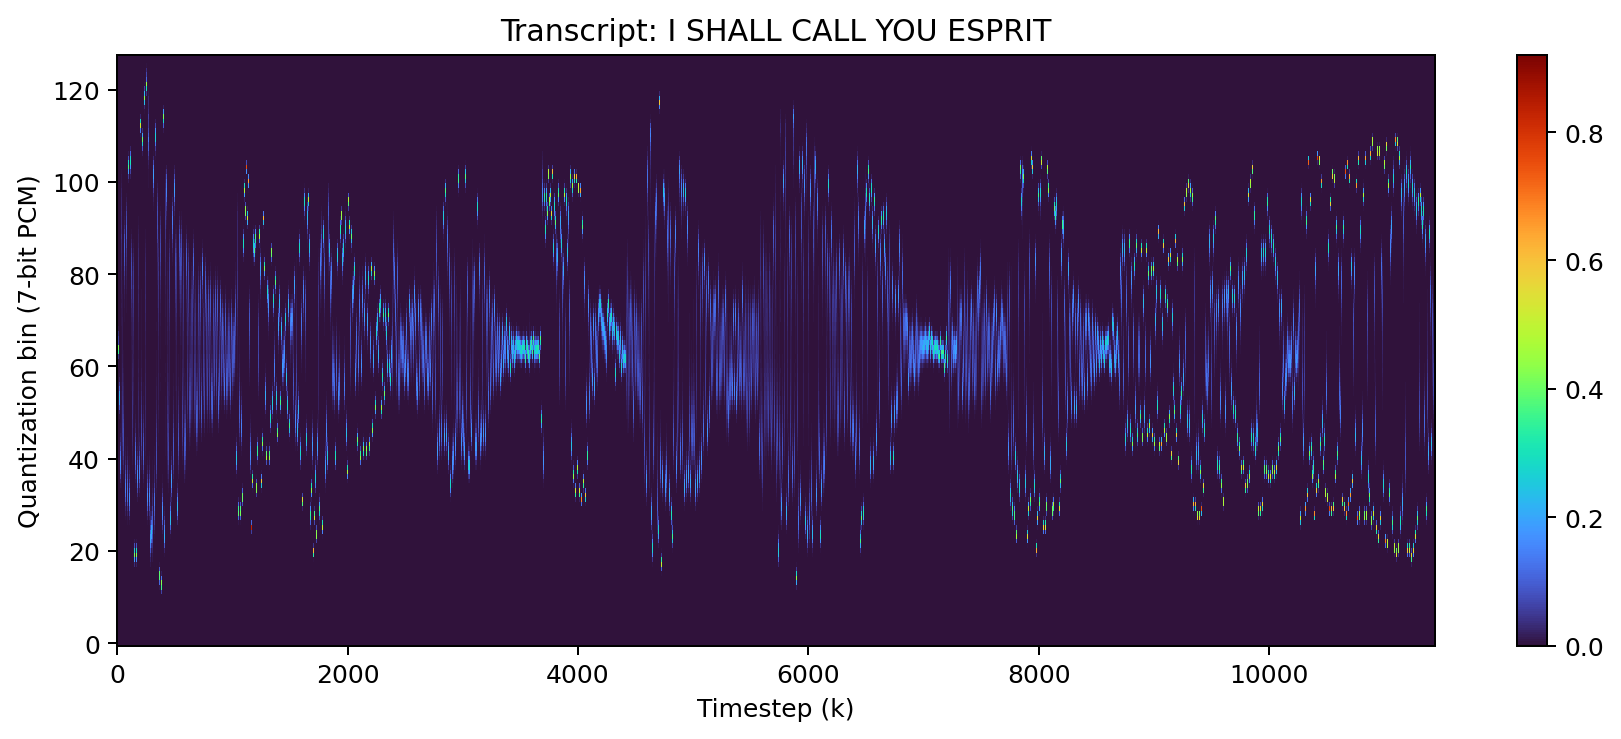

In [105]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4),dpi=180)
#plt.scatter(np.arange(len(wave)), wave, s=0.2, alpha=0.3, color=[0.5,0.0,0], marker='+')
plt.imshow(softmaxes.T, interpolation='nearest', cmap='turbo', origin='lower')
plt.colorbar()
plt.xlabel('Timestep (k)')
plt.ylabel('Quantization bin (7-bit PCM)')
plt.axis('auto')
plt.tight_layout()
plt.title('Transcript: I SHALL CALL YOU ESPRIT')
plt.savefig('softmax_wavegen.pdf', dpi=180, bbox_inches='tight')

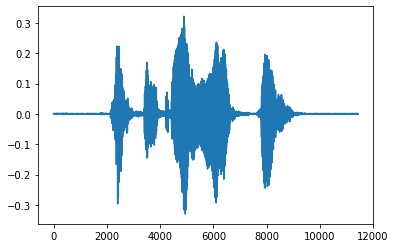

In [85]:
plt.plot(waveform.squeeze().cpu().numpy())

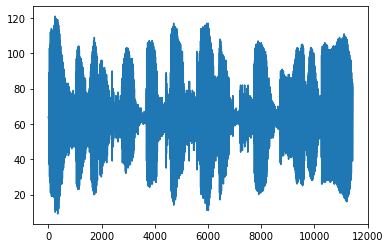

In [86]:
plt.plot(wave)